In [1]:
import sys
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error as mae, \
    mean_absolute_percentage_error as mape
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.base import clone as sklearn_clone

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
path_output_images = "./"

# Load data

In [4]:
# Read dataset generated by `synthesize_dataset.ipynb`
df_full = pd.read_parquet('./synthetic_sales_data.pq', engine='fastparquet')
df_full_with_latent = pd.read_parquet('./synthetic_sales_data_with_latent.pq', engine='fastparquet')

In [5]:
df_full.columns

Index(['store_id', 'product_id', 'product_cat_id', 'date', 'product_size',
       'promo_flag', 'price', 'sales'],
      dtype='object')

# Preprocess data

## Split

In [6]:
X_full = df_full.drop(columns=["sales"])
y_full = df_full["sales"]

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Explore data

In [7]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   store_id        13000 non-null  int64         
 1   product_id      13000 non-null  int64         
 2   product_cat_id  13000 non-null  int64         
 3   date            13000 non-null  datetime64[ns]
 4   product_size    13000 non-null  float64       
 5   promo_flag      13000 non-null  int32         
 6   price           13000 non-null  float64       
 7   sales           13000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(4)
memory usage: 761.8 KB


In [8]:
with pd.option_context('display.max_columns', None):
    display(df_full.head(10))

,store_id,product_id,product_cat_id,date,product_size,promo_flag,price,sales
0,1,1,4,2020-01-06,0.60,0,13.94,59
1,1,2,5,2020-01-06,2.00,1,1.42,196
2,1,3,3,2020-01-06,0.10,0,3.01,230
3,1,4,5,2020-01-06,0.50,0,0.60,234
4,1,5,5,2020-01-06,2.00,0,1.82,86
5,1,6,2,2020-01-06,0.15,0,2.57,164
6,1,7,3,2020-01-06,0.10,0,3.02,170
7,1,8,3,2020-01-06,0.10,0,3.19,73
8,1,9,3,2020-01-06,0.20,0,5.46,83
9,1,10,5,2020-01-06,1.00,0,1.06,140


In [9]:
df_full.describe()

,store_id,product_id,product_cat_id,date,product_size,promo_flag,price,sales
count,13000.000000,13000.00000,13000.000000,13000,13000.000000,13000.000000,13000.000000,13000.000000
mean,3.000000,50.50000,3.070000,2020-04-02 12:00:00,0.596000,0.097615,4.199845,156.301231
min,1.000000,1.00000,1.000000,2020-01-06 00:00:00,0.050000,0.000000,0.470000,15.000000
25%,2.000000,25.75000,2.000000,2020-02-17 00:00:00,0.150000,0.000000,1.120000,75.000000
50%,3.000000,50.50000,3.000000,2020-04-02 12:00:00,0.500000,0.000000,2.020000,122.000000
75%,4.000000,75.25000,4.000000,2020-05-18 00:00:00,1.000000,0.000000,5.370000,199.000000
max,5.000000,100.00000,5.000000,2020-06-29 00:00:00,2.000000,1.000000,18.210000,1163.000000
std,1.414268,28.86718,1.394722,NaN,0.575421,0.296805,4.413090,120.506593


In [10]:
df_full_with_latent.describe()

,store_id,store_mean_customers,store_std_customers,t,date,n_customers,product_id,product_cat_id,product_cat_elasticity,product_cat_size,...,product_size,product_price,product_base_demand,product_promo_lift,promo_freq,promo_flag,promo_discount,price,price_per_size,sales
count,13000.000000,13000.000000,13000.000000,13000.000000,13000,13000.000000,13000.00000,13000.000000,13000.000000,13000.000000,...,13000.000000,13000.000000,13000.000000,13000.000000,1.300000e+04,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000
mean,3.000000,1229.501487,245.900297,12.500000,2020-04-02 12:00:00,1229.569231,50.50000,3.070000,-1.635564,0.527000,...,0.596000,4.239984,0.712840,0.269000,1.000000e-01,0.097615,0.009762,4.199845,15.205822,156.301231
min,1.000000,882.923313,176.584663,0.000000,2020-01-06 00:00:00,647.000000,1.00000,1.000000,-1.902566,0.100000,...,0.050000,0.524911,0.054645,0.080000,1.000000e-01,0.000000,0.000000,0.470000,0.710000,15.000000
25%,2.000000,930.867849,186.173570,6.000000,2020-02-17 00:00:00,945.000000,25.75000,2.000000,-1.902566,0.300000,...,0.150000,1.133691,0.218580,0.160000,1.000000e-01,0.000000,0.000000,1.120000,1.080000,75.000000
50%,3.000000,1248.357077,249.671415,12.500000,2020-04-02 12:00:00,1173.500000,50.50000,3.000000,-1.671507,0.300000,...,0.500000,2.060533,0.370941,0.240000,1.000000e-01,0.000000,0.000000,2.020000,11.800000,122.000000
75%,4.000000,1323.844269,264.768854,19.000000,2020-05-18 00:00:00,1434.000000,75.25000,4.000000,-1.384157,1.000000,...,1.000000,5.374711,0.812601,0.320000,1.000000e-01,0.000000,0.000000,5.370000,27.941667,199.000000
max,5.000000,1761.514928,352.302986,25.000000,2020-06-29 00:00:00,2557.000000,100.00000,5.000000,-1.292684,1.000000,...,2.000000,18.209957,4.099026,0.480000,1.000000e-01,1.000000,0.100000,18.210000,41.200000,1163.000000
std,1.414268,316.743260,63.348652,7.500288,NaN,381.942250,28.86718,1.394722,0.237380,0.369028,...,0.575421,4.448648,0.812902,0.121376,2.775664e-17,0.296805,0.029681,4.413090,13.232728,120.506593


## Figures for the article

In [11]:
from contextlib import contextmanager

@contextmanager
def _plot_context():
    with (
        sns.axes_style("whitegrid") as a,
        sns.plotting_context("notebook", font_scale=1.2) as b,
        sns.color_palette("muted") as c,
    ):
        yield (a, b, c)

styling = {
    'context': _plot_context,
    'kwargs_annotations_scatter': dict(color="0.25", zorder=3, s=20),
}

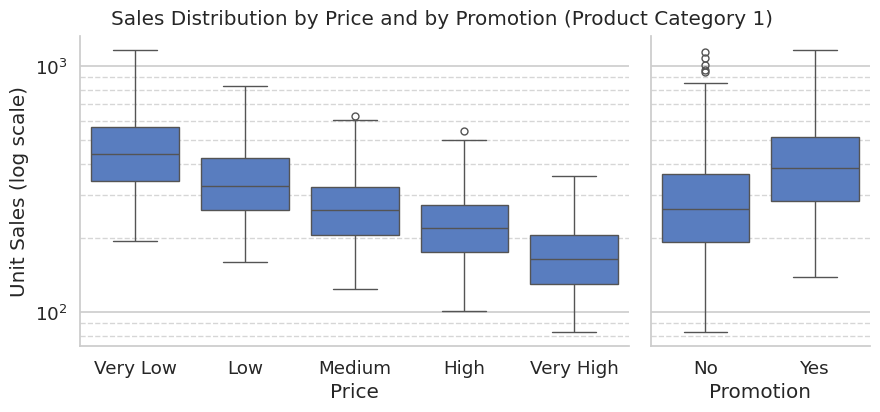

In [12]:
df = df_full_with_latent.loc[lambda df: (df['product_cat_id'] == 1)]
bin_labels = ["Very Low", "Low", "Medium", "High", "Very High"]
df = df.assign(**{
    'price_bin': pd.qcut(df['price'], 5, labels=bin_labels),
    'promo_flag_str': df['promo_flag'].map({0: 'No', 1: 'Yes'})
})

def _set_ax_style(ax):
    ax.minorticks_on()
    ax.grid(which="major", linestyle="-", linewidth=1.2, axis='y')
    ax.grid(which="minor", linestyle="--", linewidth=1.0, alpha=0.8, axis='y')

kwargs_boxplot = dict(fliersize=5)

with styling['context']():
    fig, axes = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True, gridspec_kw={'width_ratios': [5, 2]})

    ax = axes[0]
    ax = sns.boxplot(data=df, x='price_bin', y='sales', log_scale=(False, True), ax=ax, **kwargs_boxplot)
    ax.set_ylabel("Unit Sales (log scale)")
    ax.set_xlabel("Price")
    # ax.set_title("Sales vs Price")
    _set_ax_style(ax)

    ax = axes[1]
    ax = sns.boxplot(data=df, x='promo_flag_str', y='sales', log_scale=True, ax=ax, **kwargs_boxplot)
    ax.set_xlabel("Promotion")
    # ax.set_title("Sales vs Promotion")
    _set_ax_style(ax)
    fig.suptitle(
        "Sales Distribution by Price and by Promotion (Product Category 1)",
        y=0.92,
        fontsize=axes[0].title.get_fontsize()
    )

    sns.despine()
    fig.tight_layout()
fig.savefig(
    f"{path_output_images}/plot_sales_cat1.png",
    dpi=300, bbox_inches="tight", pad_inches=0.05
)

# Train models

## Helper

In [13]:
def validate_model(X_train, y_train, X_test, y_test, model):
    model = sklearn_clone(model)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    res = {
        'train_mape': mape(y_train, y_pred_train),
        'train_mae': mae(y_train, y_pred_train),
        'test_mape': mape(y_test, y_pred_test),
        'test_mae': mae(y_test, y_pred_test)
    }
    return res

## KNN

In [14]:
def prepare_features(df):
    list_product_cat_id = list(range(1, 6))
    df = df.assign(**{
        f'product_cat_id_{i}': (df['product_cat_id'] == i).astype(int) for i in list_product_cat_id
    })
    df['price_per_size'] = df['price'] / df['product_size']
    df['product_cat_id'] = df['product_cat_id'].astype('category')
    df['minus_price_per_size'] = -df['price_per_size']
    df['minus_log_price_per_size'] = -np.log(df['price_per_size'])
    df['minus_promo_flag'] = -df['promo_flag']
    df['minus_product_size'] = -df['product_size']
    df['minus_log_product_size'] = -np.log(df['product_size'])
    return df

In [15]:
features_knn = ['price_per_size', 'promo_flag', 'product_size'] \
    + [f'product_cat_id_{i}' for i in range(1, 6)]
# features_knn = ['minus_log_price_per_size', 'promo_flag', 'minus_log_product_size'] \
#     + [f'product_cat_id_{i}' for i in range(1, 6)]

model_knn = make_pipeline(
    FunctionTransformer(prepare_features),
    FunctionTransformer(lambda df: df[features_knn]),
    StandardScaler().set_output(transform='pandas'),
    TransformedTargetRegressor(
        KNeighborsRegressor(n_neighbors=5),
        func=None, # np.log1p
        inverse_func=None # np.expm1
    )
    
)

In [16]:
model_knn.fit(X_train, y_train)

,steps,"[('functiontransformer-1', ...), ('functiontransformer-2', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function pre...0023653CCBCE0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [17]:
validate_model(X_train, y_train, X_test, y_test, model_knn)

{'train_mape': 0.27699484573426975,
 'train_mae': 41.53192307692308,
 'test_mape': 0.2750108721186808,
 'test_mae': 41.62092307692308}

In [18]:
def plot_response_curve(
    X_one,
    model,
    col='price',
    val_range=np.arange(0.05, 5.0 + 1e-5, 0.01),
    x_to_annotate=[],
    title="How Predicted Sales Change with Price",
    annotation_offset=(10, 0),
    annotation_va='center',
    xmin=0,
):
    X1 = X_one.assign(**{col: [val_range]}).explode(col)
    X1[col] = X1[col].astype(float)

    with styling['context']():
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(X1[col], model.predict(X1))
        ax.set_ylabel("Predicted Sales")
        ax.set_xlabel("Price")
        ax.set_title(f"{title}")
        for x in x_to_annotate:
            X_temp = X1.iloc[[0]].assign(**{col: x})
            y = model.predict(X_temp)[0]
            ax.annotate(
                text=f"Price={x:.2f}, Sales={y:.0f}",
                xy=(x, y),
                xytext=annotation_offset,
                textcoords="offset points",
                fontsize=12,
                va=annotation_va
            )
            ax.scatter([x], [y], **styling['kwargs_annotations_scatter'])
        fig.tight_layout()
        if xmin is not None:
            ax.set_xlim(left=xmin)
    return fig

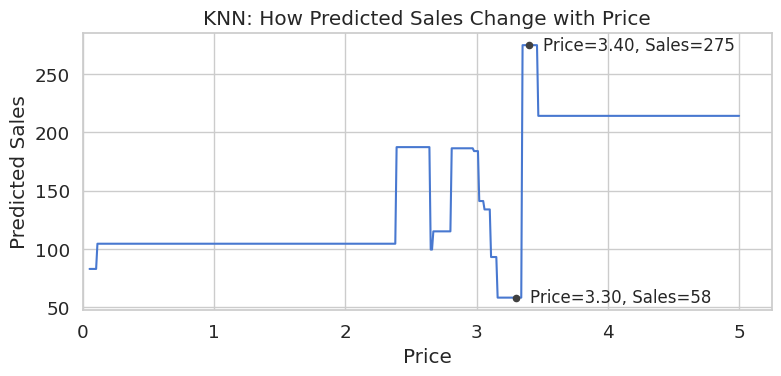

In [19]:
idx = 8
fig = plot_response_curve(
    X_train.iloc[[idx]],
    model_knn,
    x_to_annotate=[3.3, 3.4],
    title="KNN: How Predicted Sales Change with Price"
)
fig.savefig(
    f"{path_output_images}/sales-vs-price-knn.png",
    dpi=300, bbox_inches="tight", pad_inches=0.05
)

In [20]:
X2 = X_train.copy().drop('promo_flag', axis=1)
X2['pred_promo'] = model_knn.predict(X_train.assign(**{'promo_flag': 1}))
X2['pred_no_promo'] = model_knn.predict(X_train.assign(**{'promo_flag': 0}))
print((X2['pred_promo'] < X2['pred_no_promo']).mean())
X2.loc[X2['pred_no_promo'] > X2['pred_promo']].head()


0.22288461538461538


,store_id,product_id,product_cat_id,date,product_size,price,pred_promo,pred_no_promo
12991,5,92,1,2020-06-29,2.0,1.70,199.4,215.2
3043,2,44,2,2020-02-03,0.6,5.26,111.6,127.4
3369,2,70,4,2020-02-24,0.6,16.18,71.8,86.8
9727,4,28,2,2020-05-18,0.6,5.75,58.0,69.4
4785,2,86,1,2020-06-01,1.0,0.99,284.8,294.4


## LGBM

In [21]:
features_lgbm = ['price_per_size', 'promo_flag', 'product_size', 'product_cat_id']
dict_mc = {'price_per_size': -1, 'promo_flag': 1}
mc = [dict_mc.get(col, 0) for col in features_lgbm]
model_lgbm = make_pipeline(
    FunctionTransformer(prepare_features),
    FunctionTransformer(lambda df: df[features_lgbm]),
    TransformedTargetRegressor(
        LGBMRegressor(monotone_constraints=mc, verbose=-1, random_state=42),
        func=None, # np.log1p,
        inverse_func=None # np.expm1,
    )
    
)

In [22]:
model_lgbm[:-1].fit_transform(X_train.iloc[:5])

,price_per_size,promo_flag,product_size,product_cat_id
10970,1.080000,0,0.50,1
12991,0.850000,0,2.00,1
563,10.600000,0,0.15,2
1905,17.133333,0,0.15,2
5778,41.200000,0,0.15,4


In [23]:
model_lgbm.fit(X_train, y_train)

,steps,"[('functiontransformer-1', ...), ('functiontransformer-2', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function pre...0023653CCBCE0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [24]:
validate_model(X_train, y_train, X_test, y_test, model_lgbm)

{'train_mape': 0.2985978061400793,
 'train_mae': 41.40405582860735,
 'test_mape': 0.2938925651723256,
 'test_mae': 41.366815914426084}

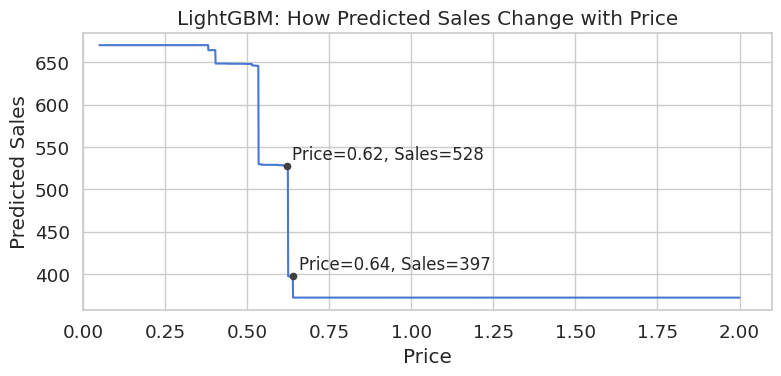

In [25]:
idx = 0
fig = plot_response_curve(
    X_train.iloc[[idx]],
    model_lgbm,
    x_to_annotate=[0.62, 0.64],
    val_range=np.arange(0.05, 2 + 2e-5, 0.001),
    title="LightGBM: How Predicted Sales Change with Price",
    annotation_offset=(4, 2),
    annotation_va='bottom'
)
fig.savefig(
    f"{path_output_images}/sales-vs-price-lgbm.png",
    dpi=300, bbox_inches="tight", pad_inches=0.05
)

In [26]:
X2 = X_train.copy().drop('promo_flag', axis=1)
X2['pred_promo'] = model_lgbm.predict(X_train.assign(**{'promo_flag': 1}))
X2['pred_no_promo'] = model_lgbm.predict(X_train.assign(**{'promo_flag': 0}))
print((X2['pred_promo'] < X2['pred_no_promo']).mean())
display(X2.loc[X2['pred_no_promo'] > X2['pred_promo']].head())
print((X2['pred_promo'] / X2['pred_no_promo']).max())

0.0


,store_id,product_id,product_cat_id,date,product_size,price,pred_promo,pred_no_promo


2.441879977903136


# Linear

In [27]:
# First attempt: straightforward
features_linear = ['minus_price_per_size', 'promo_flag', 'minus_product_size']

model_linear = make_pipeline(
    FunctionTransformer(prepare_features),
    FunctionTransformer(lambda df: df[features_linear]),
    LinearRegression(positive=True)
)
model_linear.fit(X_train, y_train)

,steps,"[('functiontransformer-1', ...), ('functiontransformer-2', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function pre...0023653CCBCE0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [28]:
validate_model(X_train, y_train, X_test, y_test, model_linear)

{'train_mape': 0.7121575375352133,
 'train_mae': 76.94807640394613,
 'test_mape': 0.7059437508906593,
 'test_mae': 76.59065604748798}

In [29]:
# More careful with model formulation
features_linear = [
    'minus_log_price_per_size', 'promo_flag', 'minus_log_product_size',
    *[f'product_cat_id_{i}' for i in range(1, 6)]
]
model_linear = make_pipeline(
    FunctionTransformer(prepare_features),
    FunctionTransformer(lambda df: df[features_linear]),
    TransformedTargetRegressor(
        LinearRegression(
            positive=True   # Set all coefficients to be positive (or zero)
        ),
        func=np.log1p,      # Log-transform the target
        inverse_func=np.expm1
    )
)

In [30]:
model_linear[:-1].fit_transform(X_train.iloc[:5])

,minus_log_price_per_size,promo_flag,minus_log_product_size,product_cat_id_1,product_cat_id_2,product_cat_id_3,product_cat_id_4,product_cat_id_5
10970,-0.076961,0,0.693147,1,0,0,0,0
12991,0.162519,0,-0.693147,1,0,0,0,0
563,-2.360854,0,1.897120,0,1,0,0,0
1905,-2.841026,0,1.897120,0,1,0,0,0
5778,-3.718438,0,1.897120,0,0,0,1,0


In [31]:
model_linear.fit(X_train, y_train)

,steps,"[('functiontransformer-1', ...), ('functiontransformer-2', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function pre...0023653CCBCE0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [32]:
validate_model(X_train, y_train, X_test, y_test, model_linear)

{'train_mape': 0.3205604322468033,
 'train_mae': 44.93568178581857,
 'test_mape': 0.306600535551922,
 'test_mae': 43.762276955912554}

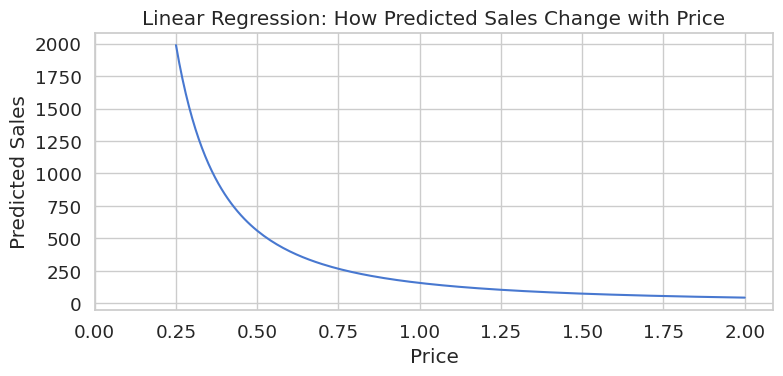

In [33]:
idx = 0
seen_prices = X_train.iloc[[idx]][['product_id']].merge(X_train)['price']
fig = plot_response_curve(
    X_train.iloc[[idx]],
    model_linear,
    val_range=np.arange(0.25, 2.0 + 1e-5, 0.01),
    # x_to_annotate=[seen_prices.mean()],
    # x_to_annotate=[seen_prices.min(), seen_prices.max()],
    # x_to_annotate=[seen_prices.mean() - 3 * seen_prices.std(), seen_prices.mean() + 3 * seen_prices.std()],
    title="Linear Regression: How Predicted Sales Change with Price",
    annotation_offset=(5, 5)
)
# ax = fig.axes[0]
# x, y = ax.get_lines()[0].get_data()
# mask = (x >= seen_prices.min()) & (x <= seen_prices.max())
# ax.plot(x[mask], y[mask], color="0.25", lw=3.0, label="Seen in the Trainset")
# ax.legend()

# ann1, ann2 = fig.axes[0].texts
# ann1.set_text("")
# ann2.set_text("")

# fig.axes[0].texts[0].set_text("Mean Price in the Trainset")
fig.savefig(
    f"{path_output_images}/sales-vs-price-linreg.png",
    dpi=300, bbox_inches="tight", pad_inches=0.05
)
